In [ ]:
!pip install -q numpy==1.24.3 scikit-learn==1.3.2 xgboost imbalanced-learn shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap


In [ ]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']
df = pd.read_csv(url, names=columns)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


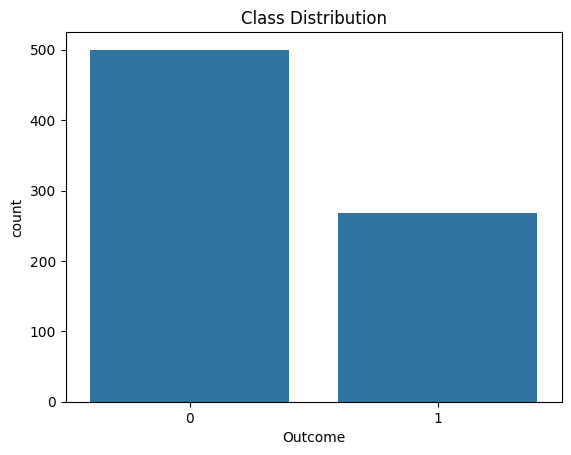

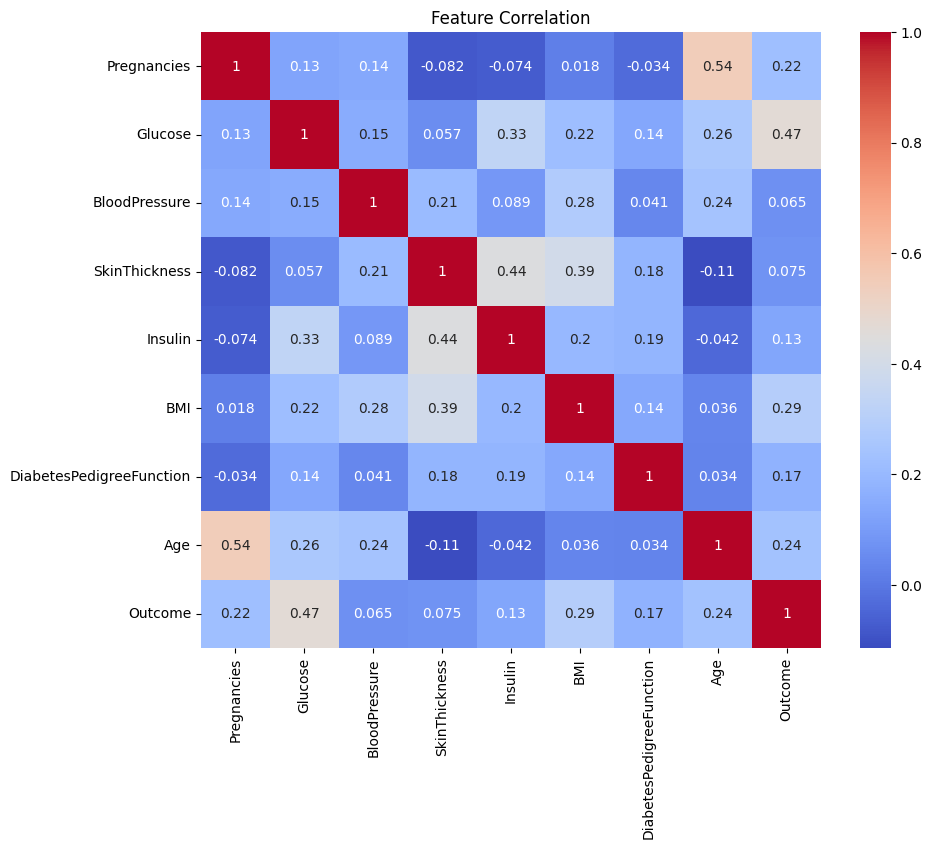

In [ ]:
df.info()
df.describe()

sns.countplot(data=df, x='Outcome')
plt.title('Class Distribution')
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()


In [ ]:
invalid_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for col in invalid_cols:
    df[col] = df[col].replace(0, np.nan)

imputer = SimpleImputer(strategy='mean')
df[invalid_cols] = imputer.fit_transform(df[invalid_cols])


In [ ]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds))
    print("Recall:", recall_score(y_test, preds))
    print("F1-score:", f1_score(y_test, preds))
    print("ROC AUC:", roc_auc_score(y_test, proba))
    print("\nClassification Report:\n", classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.legend()
    plt.title('ROC Curve')
    plt.show()


=== Logistic Regression ===
Accuracy: 0.7142857142857143
Precision: 0.5806451612903226
Recall: 0.6666666666666666
F1-score: 0.6206896551724138
ROC AUC: 0.8077777777777778

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       100
           1       0.58      0.67      0.62        54

    accuracy                           0.71       154
   macro avg       0.69      0.70      0.70       154
weighted avg       0.73      0.71      0.72       154



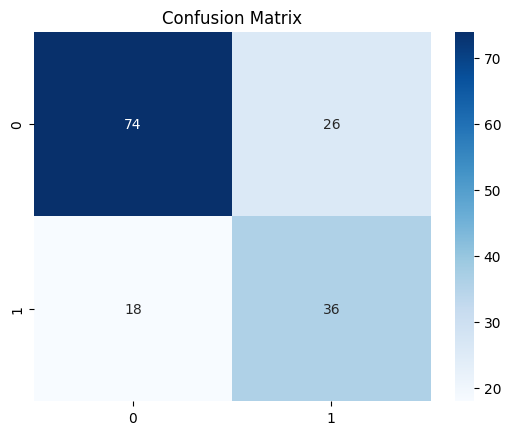

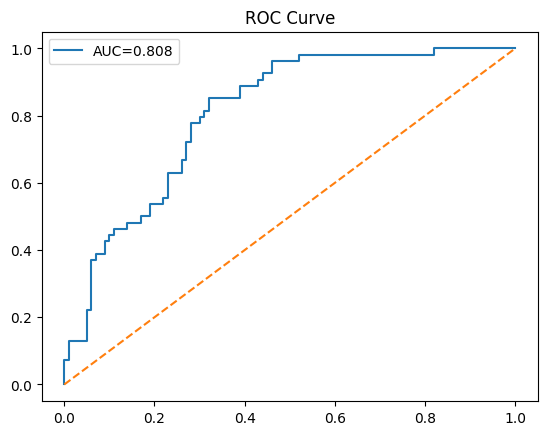

In [ ]:
print("=== Logistic Regression ===")
lr = LogisticRegression(max_iter=500)
evaluate_model(lr, X_train_res, y_train_res, X_test, y_test)


=== Random Forest ===
Accuracy: 0.7337662337662337
Precision: 0.6140350877192983
Recall: 0.6481481481481481
F1-score: 0.6306306306306307
ROC AUC: 0.817037037037037

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79       100
           1       0.61      0.65      0.63        54

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.74      0.73      0.74       154



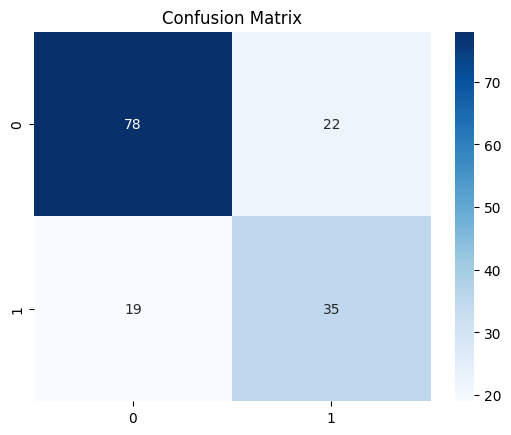

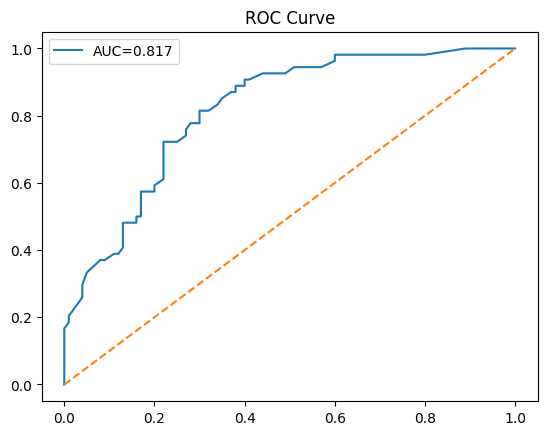

In [ ]:
print("=== Random Forest ===")
rf = RandomForestClassifier(random_state=42)
evaluate_model(rf, X_train_res, y_train_res, X_test, y_test)


=== XGBoost ===
Accuracy: 0.7337662337662337
Precision: 0.6181818181818182
Recall: 0.6296296296296297
F1-score: 0.6238532110091743
ROC AUC: 0.7981481481481482

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.79      0.79       100
           1       0.62      0.63      0.62        54

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154



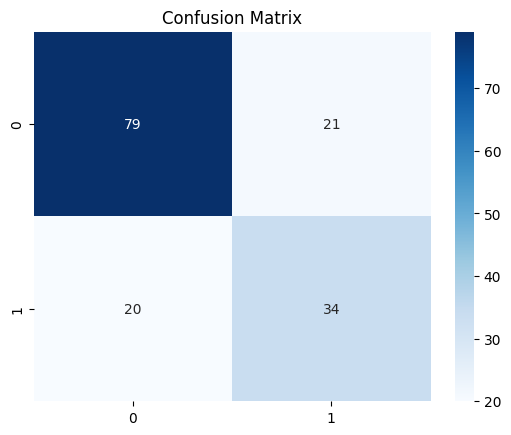

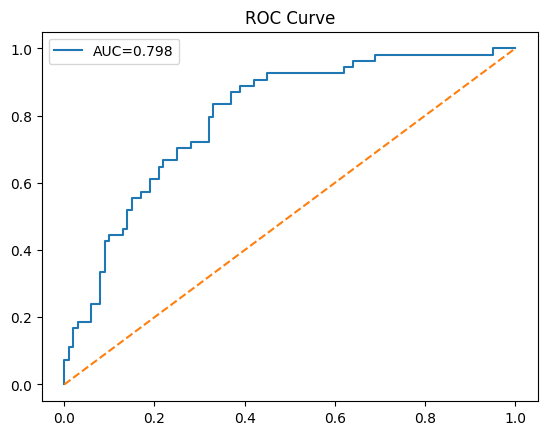

In [ ]:
print("=== XGBoost ===")
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
evaluate_model(xgb, X_train_res, y_train_res, X_test, y_test)


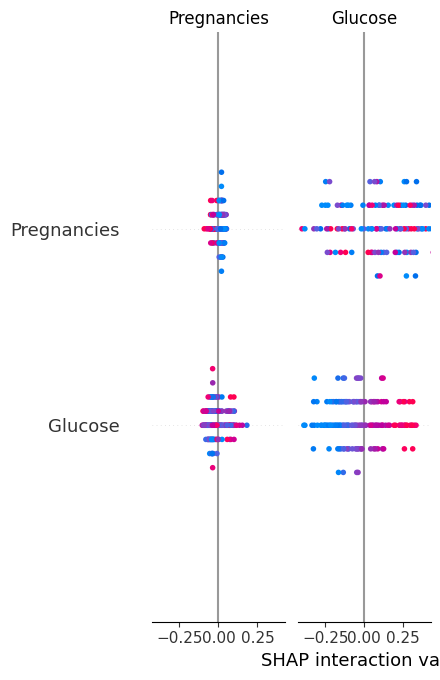

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_values_to_plot = shap_values
feature_names = X_test.columns if hasattr(X_test, 'columns') else columns[:-1]
shap.summary_plot(shap_values_to_plot, X_test, feature_names=feature_names)


In [ ]:
def predict_diabetes(input_data):
    arr = np.array(input_data).reshape(1, -1)
    arr_scaled = scaler.transform(arr)
    pred = rf.predict(arr_scaled)[0]
    return "Diabetic" if pred == 1 else "Not Diabetic"

sample = [2,120,70,20,79,25.0,0.5,33]
print("Prediction:", predict_diabetes(sample))


Prediction: Not Diabetic
